# Yelp Restaurant Reviews Summarizer 
- **Objective**:  Boost Yelp website engagement by summarizing restaurant reviews, enabling efficient, informed customer decisions.
- **Problem Statement**: The vast number of reviews, ranging from positive to negative, makes it time-consuming for customers to quickly assess restaurant feedback.
- **Method**: Summarize reviews by processing 7M+ data points, selecting relevant reviews, and using LLMs (Gemini Flash, Meta Lama 3).
- **Tools**:  Tableau, Databricks, Python, SparkSQL, Llama 3.1, Gemini Flash, LangChain

# Table of Contents 

1. **Setup and Data: Load all the required data**
  - 1A. Understanding the Structure of the Business Data
  - 1B. Understanding Tip Data
  - 1C. Exploring the Structure & Content of the categories.json file
2. **Data Preparation: Wrangling the relevant data for summarization**
  - 2A. Prepare Restaurant Business Categories
  - 2B. Selecting Other Top Categories Coincide with Restaurant
  - 2C. Preparing and Analyzing Tip Table for Summarization
  - 2D. Understanding the Relationship Between Restaurants & Their Metro Area (metro_restaurant_table) 
  - 2E. Identifying the Reviews for Restaurants (restaurant_review)
  - 2F. Understanding the Relationship between Users and Restaurant Reviews (restaurant_reviews_for_summarization)
  - 2G. Refining & Structuring All Relevant Data for Analysis

## Introducing Tables

- [Yelp Dataset JSON](https://www.yelp.com/dataset/documentation/main)
- **Review Table** - This table stores individual reviews created by users for different businesses.
- **Users Table** - This table consists of 1,987,897 Yelp users. We will be using the reviews from these users for our summarization data.
- **Filtered Restaurant Table** - This is the resulting table after filtering out certain categories that do not correlate to a restaurant. This data excludes businesses that we do not consider restaurants, to enhance our restaurant review data for summarization. Overall, it consists of 10,685 remaining restaurants.
- **Metro Table** - This table consists of the 11 metro areas that the business in our dataset correlate to. 

# 1. Setup and Data 
This section details the process of loading the data and setting up the proper tables/dataframes.

* Yelp data was downloaded through Kaggle before it was imported into Databricks in bzip2 format to save space: [Kaggle Yelp Dataset](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/data)
* To ensure that we are using the correct version of the Yelp data (data is always being updated), we have also created a small JSON File containing these parameters
* `categories.json` file was then imported through the GUI interface and copied from the FileStore path into the Yelp path in Databricks
* `categories.json` was created into a dataframe using PySpark. But before we could use SQL to wrangle the data, the categories dataframe must be created into a Temporary View to ensure that it is stored into memory. This file contains all of the top level categories from Yelp that businesses are sorted into, such as, “Food” and “Shopping,” and even “Public Services & Government.” We will later start filtering out irrelevant categories that are not related to restaurants to do our restaurant reviews summarization to ensure the data is as accurate as can be.
* `business.bz2` file was created into a dataframe as well as a Temporary View. It is used to filter out which top-level categories should be ok to include with a restaurant
* In order to start filtering, another dataframe is created, `filtered_restaurants,` that builds on the temporary view `restaurants`
* `metro_areas.csv` generated from Tableau will then be from wrangling the business file from Data Explorer from the Yelp Dataset on Kaggle. We categorized all the businesses in each metro area according to the major city in those areas, which was then visualized on a map of the US and Canada. This was then made into a dataframe. metro areas. The organized data of businesses and their metro areas were then imported into a csv file, named metro_areas.csv, that is the basis of much of our deepdive into the restaurants and metro areas. 
[View Tableau Visualization](https://public.tableau.com/views/MappingMetroAreas_17304289481960/MappingMetroAreas?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)


%md
### Business Data 
The Restaurant Reviews data includes the following fields and examples: 
- "business_id":string"Pns2l4eNsfO8kk83dixA6A"
- "name":string"Abby Rappoport, LAC, CMQ"
- "address":string"1616 Chapala St, Ste 2"
- "city":string"Santa Barbara"
- "state":string"CA"
- "postal_code":string"93101"
- "latitude":float34.4266787
- "longitude":float-119.7111968
- "stars":int5
- "review_count":int7
- "is_open":int0
- "ByAppointmentOnly":string"True"

1. The business data can be accessed through [Kaggle](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset?select=yelp_academic_dataset_business.jsonhttps://www.kaggle.com/datasets/yelp-dataset/yelp-dataset?select=yelp_academic_dataset_business.json)

2. Download the second file: yelp_academic_dataset_business.json

In [0]:
dbutils

Out[1]: Package 'dbutils'. For more information, type 'dbutils.help()' in a cell.

##1A. Understanding the Structure of the Business Data
* Yelp's business dataset is loaded into a dataframe. We then printed the record number of business records, which resulted in 150,346 business records total. We then printed the schema of the business dataset. Lastly, we showed a sample of the first 20 rows.
* This helps us understand the structure of the business data and evaluate the quality and completeness of the data. This process of loading and inspecting the dataset is a critical first step in preparing the data for further analysis.

In [0]:
df_raw_business = spark.read.json("/yelp/business.bz2")

print("record count:", df_raw_business.count())
df_raw_business.printSchema()
df_raw_business.show(20,truncate=100,vertical=True)

record count: 150346
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-

## 1B. Understanding Tip Data
* We first uploaded the tip json file. We also printed the schema and the first 20 records. Lastly, we printed the total tip records, which is 908,915.
* This step is fundamental in preparing the data for deeper insights or using it in predictive models or other analyses. 
* It allows deeper understanding of tip data, schema exploration, and further data analysis.


In [0]:
df_raw_tips = spark.read.json("/yelp/tip.bz2")

print("record count:", df_raw_tips.count())
df_raw_tips.printSchema()
df_raw_tips.show(20,truncate=100,vertical=True)

record count: 908915
root
 |-- business_id: string (nullable = true)
 |-- compliment_count: long (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: string (nullable = true)

-RECORD 0----------------------------------------------------------------------------------------------------------------
 business_id      | 3uLgwr0qeCNMjKenHJwPGQ                                                                               
 compliment_count | 0                                                                                                    
 date             | 2012-05-18 02:17:21                                                                                  
 text             | Avengers time with the ladies.                                                                       
 user_id          | AGNUgVwnZUey3gcPCJ76iw                                                                               
-RECORD 1--------------------------------

## 1C. Exploring the Structure & Content of the categories.json file 
* We created a categories dataframe from categories dataset. We then printed the total categories, which resulted in 1,565 Yelp categories. We then showed the schema and printed the first 20 samples
* The code helps in exploring the structure and content of the categories.json file. 
* This could be useful for understanding what categories exist in the Yelp data (e.g., business categories like "Restaurants", "Coffee", etc.), how many categories there are, and what data is available for each category.
* By counting the records and showing the first few rows, we can get a quick overview of how many categories exist and see sample data.



In [0]:
# 1 - create a dataframe
df_categories = spark.read.option("multiLine",True).json("/yelp/categories.json")
print( "number of categories:", df_categories.count())
df_categories.show()
df_categories.printSchema()
df_categories.show(20, truncate = 100)

number of categories: 1565
+------------------+--------------------+-----------------+---------------+-------------------+
|             alias|   country_blacklist|country_whitelist|        parents|              title|
+------------------+--------------------+-----------------+---------------+-------------------+
|        3dprinting|                null|             null|[localservices]|        3D Printing|
|         abruzzese|                null|             [IT]|      [italian]|          Abruzzese|
|      absinthebars|                null|             [CZ]|         [bars]|      Absinthe Bars|
|         acaibowls|[MX, PL, AR, TR, ...|             null|         [food]|         Acai Bowls|
|       accessories|                null|             null|      [fashion]|        Accessories|
|       accountants|                null|             null| [professional]|        Accountants|
|     acnetreatment|                null|             null|    [beautysvc]|     Acne Treatment|
|            

# 2. Data Preparation 
We wrangled and filtered the data to prep it for summarization. 

We used:
- Business Data 
  - Fields Selection 
  -  Top Categories Selection 
- Tips Data
- Review Table 
- User Table 
- Metro Table 


## 2A. Preparing Restaurant Business Categories



### 2A.1 Choosing Relevant Business Attributes
* We chose the attributes that we thought were most relevant for each restaurant in our data. This includes the business_id, name, categories, stars, and review_count.
* **Business_id** - This is the restaurant’s business ID that is unique to each business. This will allow us to differentiate between businesses and analyze data without other unique attributes.
* **Name** - This is the business’ name, which is useful for us to search the business and do further research. This allows us to dive deeper into information that we otherwise would not have discovered with our code, such as what the business looks like.
* **Stars** - The number of stars a business has allows us to get a general sense of the ratings of the business. The higher number of stars, the more positive the reviews are likely to be. 
* **Review_count** - The review count lets us know how many reviews a business has on Yelp, and allows us to determine how many reviews we should analyze to get a proper sample size of our analysis. For example, if a restaurant has only a few reviews, each review has a higher weight than if the restaurant had more overall reviews. This should be taken into consideration when analyzing the reviews of a restaurant for the majority’s opinion.
* **Categories** - The categories associated with each business allows us to get a sense of which businesses are restaurants or not. This was filtered with our team’s reasoning and deeper analysis to the results of the businesses in each category. Our goal was to include categories and subcategories that would support restaurant reviews.
* **is_open** - We want to only summarize restaurants that are still open, as the objective is to provide customers for assessment of dining and reviewing current opened restaurants. It would not be beneficial to analyze or summarize businesses that are no longer in business.


In [0]:
df_raw_business.createOrReplaceTempView("raw_business")

df_business = spark.sql("""
SELECT business_id, name, stars, review_count, categories
FROM raw_business
WHERE is_open = 1
""")
df_business.show(vertical = True, truncate = False)

df_business.createOrReplaceTempView("business")

-RECORD 0--------------------------------------------------------------------------------------
 business_id  | mpf3x-BjTdTEA3yCZrAYPw                                                         
 name         | The UPS Store                                                                  
 stars        | 3.0                                                                            
 review_count | 15                                                                             
 categories   | Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services 
-RECORD 1--------------------------------------------------------------------------------------
 business_id  | MTSW4McQd7CbVtyjqoe9mw                                                         
 name         | St Honore Pastries                                                             
 stars        | 4.0                                                                            
 review_count | 80                      

###2A.2 Visualizing Distribution of Review Stars

##### Review Stars 
* For example, this histogram shows the number of business reviews on a range of 1 star to 5 stars. Since we can see there are more reviews that are closer to 5 stars, we can expect the summarization to be generally positive. Additionally, we can assume that there are not a lot of strong negative opinions in these reviews.
* The histogram is right skewed, meaning restaurants overall have higher ratings.
Top 25% of restaurants have more than 4.5 star rating, Top 50% of restaurants have more than 4 star rating; while only 25% of restaurants have lower than 3 star rating.
* This shows that restaurants with 3 stars or more are very common. Customers may find it challenging to distinguish the best restaurant among those with 5-star ratings, as 12% of restaurants have an average review score of 5 stars.



+-----+-----+
|stars|count|
+-----+-----+
|  1.0| 1671|
|  1.5| 4150|
|  2.0| 7781|
|  2.5|11211|
|  3.0|13725|
|  3.5|19859|
|  4.0|24228|
|  4.5|22536|
|  5.0|14537|
+-----+-----+



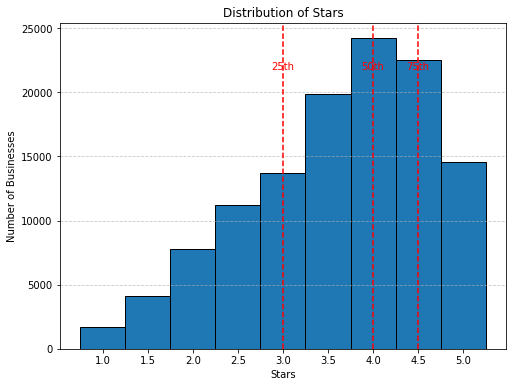

In [0]:
import matplotlib.pyplot as plt

star_distribution = spark.sql("""
SELECT stars, COUNT(*) as count
FROM business
GROUP BY stars
ORDER BY stars
""")

# Compute percentiles (25th, 50th, 75th) using Spark SQL
percentiles = spark.sql("""
SELECT 
    PERCENTILE(stars, 0.25) AS p25,
    PERCENTILE(stars, 0.50) AS p50,
    PERCENTILE(stars, 0.75) AS p75
FROM business
""")
percentiles_pd = percentiles.toPandas()

# Extract the percentile values
p25, p50, p75 = percentiles_pd.iloc[0]['p25'], percentiles_pd.iloc[0]['p50'], percentiles_pd.iloc[0]['p75']


star_distribution.show()

star_distribution_pd = star_distribution.toPandas()

plt.figure(figsize=(8, 6))
plt.bar(star_distribution_pd['stars'], star_distribution_pd['count'], width=0.5, edgecolor='black')

# Add vertical lines for the percentiles
plt.axvline(x=p25, color='red', linestyle='--', linewidth=1.5, label='25th Percentile (P25)')
plt.axvline(x=p50, color='red', linestyle='--', linewidth=1.5, label='50th Percentile (Median, P50)')
plt.axvline(x=p75, color='red', linestyle='--', linewidth=1.5, label='75th Percentile (P75)')

# Annotate the percentiles on the figure
plt.text(p25, max(star_distribution_pd['count']) * 0.9, "25th", color='red', ha='center')
plt.text(p50, max(star_distribution_pd['count']) * 0.9, "50th", color='red', ha='center')
plt.text(p75, max(star_distribution_pd['count']) * 0.9, "75th", color='red', ha='center')

plt.title("Distribution of Stars")
plt.xlabel("Stars")
plt.ylabel("Number of Businesses")
plt.xticks(star_distribution_pd['stars'])  # Ensure proper tick marks for stars
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


##### Visualizing Review Count of Businesses

* From the boxplot, we can see that half of the restaurants receive at least 15 reviews from customers, with 25% of restaurants receiving more than 37 reviews and 25% restaurants receiving less than 8 reviews.
* The higher of a review count a business has, the more credible the overall star count and summarization will be. The opinion of a group of people is more trustworthy than the opinion of a couple individuals. 



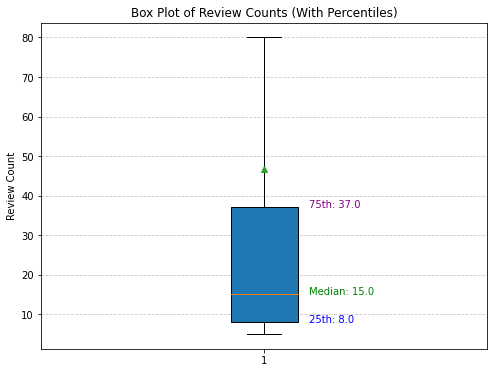

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Query to extract review_count from the dataset
review_count_data = spark.sql("""
SELECT review_count
FROM business
""")

# Convert the review_count data to Pandas for plotting
review_count_pd = review_count_data.toPandas()

# Calculate percentiles (25th, 50th, and 75th)
p25 = np.percentile(review_count_pd['review_count'], 25)
p50 = np.percentile(review_count_pd['review_count'], 50)  # Median
p75 = np.percentile(review_count_pd['review_count'], 75)

# Plotting the box plot without outliers
plt.figure(figsize=(8, 6))
box = plt.boxplot(
    review_count_pd['review_count'],
    vert=True,
    patch_artist=True,
    showmeans=True,
    showfliers=False  # Exclude outliers
)

# Add percentile annotations
plt.text(1.1, p25, f"25th: {p25:.1f}", color='blue', ha='left')
plt.text(1.1, p50, f"Median: {p50:.1f}", color='green', ha='left')
plt.text(1.1, p75, f"75th: {p75:.1f}", color='purple', ha='left')

# Add labels and title
plt.title("Box Plot of Review Counts (With Percentiles)")
plt.ylabel("Review Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


###2A.3 Identifying the Top Categories for Businesses in Yelp
* We first created a categories dataframe. We then filtered the top categories (those with parents == 0). Then, we showed the first 30 samples of top categories.
* By identifying the top categories, we are able to research deeper into the businesses and the subcategory they fall under. We will later decide if we choose to include those particular businesses, categories, or subcategories into our summarization or consideration.


In [0]:
df_categories.createOrReplaceTempView("categories")

import pyspark.sql.functions as f
df_categories.filter( f.size(df_categories.parents) == 0 ).show(30, truncate=False)

+------------------+-----------------+-----------------+-------+----------------------------+
|alias             |country_blacklist|country_whitelist|parents|title                       |
+------------------+-----------------+-----------------+-------+----------------------------+
|active            |null             |null             |[]     |Active Life                 |
|arts              |null             |null             |[]     |Arts & Entertainment        |
|auto              |null             |null             |[]     |Automotive                  |
|beautysvc         |null             |null             |[]     |Beauty & Spas               |
|bicycles          |null             |[PL, PT, DK, CZ] |[]     |Bicycles                    |
|education         |null             |null             |[]     |Education                   |
|eventservices     |null             |null             |[]     |Event Planning & Services   |
|financialservices |null             |null             |[]  

###2A.4 Identifying the Values & Categories of Businesses
* From the business dataframe we isolated the categories field from all other fields. We then split the values and then the categories. This gives us an overview of the businesses, their business ID, the name, the stars rating and number of reviews an individual business has. 
* This also allows us to see what categories each business belongs to, to get a sense of what kind of reviews the businesses would receive according to their services.

In [0]:
df_business.select("business_id", "name", "stars", "review_count", f.split(df_business.categories,'\s*,\s*').alias("categories")).show(10, truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------------------------
 business_id  | mpf3x-BjTdTEA3yCZrAYPw                                                           
 name         | The UPS Store                                                                    
 stars        | 3.0                                                                              
 review_count | 15                                                                               
 categories   | [Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services] 
-RECORD 1----------------------------------------------------------------------------------------
 business_id  | MTSW4McQd7CbVtyjqoe9mw                                                           
 name         | St Honore Pastries                                                               
 stars        | 4.0                                                                              
 review_count | 80  

###2A.5 Extracting & Categorizing Null Businesses
* To narrow down our data to provide more relevant information for the summarizer to produce accurate results of the businesses, we should not take businesses that are no longer open into account. 
* Additionally, without the irrelevant data, the operational efficiency is improved, and provides more insights into review counts and ratings.
* We first created a dataframe called df_business_cat
* We split the values of the categories. Then, we filtered the data to exclude records with empty categories. 
* We printed the record count of our result, which comes to be 119,603 businesses. 
* We showed a sample of the first 10 businesses. This will simplify our analysis and strengthen our summarization to be relevant.

In [0]:
df_business_cat = spark.sql("""
SELECT business_id, name, stars, review_count, 
        SPLIT(categories,'\\\s*,\\\s*') AS categories
FROM business
WHERE categories IS NOT NULL
""")

print("record count:", df_business_cat.count())

df_business_cat.show(10, truncate=False, vertical=True)

record count: 119603
-RECORD 0----------------------------------------------------------------------------------------
 business_id  | mpf3x-BjTdTEA3yCZrAYPw                                                           
 name         | The UPS Store                                                                    
 stars        | 3.0                                                                              
 review_count | 15                                                                               
 categories   | [Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services] 
-RECORD 1----------------------------------------------------------------------------------------
 business_id  | MTSW4McQd7CbVtyjqoe9mw                                                           
 name         | St Honore Pastries                                                               
 stars        | 4.0                                                                              

###2A.6 Filtering & Preparing Restaurant & Category Specific Data
* This allows us to focus our analysis on relevant data and narrow down to restaurants to be more efficient. 
* This lets us further analyze the restaurants and their data without any unnecessary information.
* By focusing solely on restaurants, it allows the summarizer to analyze and derive insights from a specific and relevant subset of data.
* We first created a temporary view from our df_business_cat dataframe. We then filtered the result to only show records that include "Restaurants" categories. We then printed the total restaurant records, which is 34,987. We then showed a sample of the first 10 restaurants. Then we created a temporary view of the restaurants.

In [0]:
df_business_cat.createOrReplaceTempView("business_cat")

df_restaurants = spark.sql("""
SELECT *
FROM business_cat
WHERE ARRAY_CONTAINS(categories,"Restaurants")
""")

print("record count:", df_restaurants.count())
df_restaurants.show(truncate=False, vertical=True)

df_restaurants.createOrReplaceTempView("restaurants")

record count: 34987
-RECORD 0-----------------------------------------------------------------------------------------------------------------------
 business_id  | MTSW4McQd7CbVtyjqoe9mw                                                                                          
 name         | St Honore Pastries                                                                                              
 stars        | 4.0                                                                                                             
 review_count | 80                                                                                                              
 categories   | [Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries]                                                         
-RECORD 1-----------------------------------------------------------------------------------------------------------------------
 business_id  | CF33F8-E6oudUQ46HnavjQ                                       

## 2B. Selecting Other Top Categories Coincide with Restaurant

[Yelp Category List](https://blog.yelp.com/businesses/yelp_category_list/)

###Included Categories:
These following categories are included in our data because of the results’ strong relationship with “Restaurant.”

To filter the results even more, there were a few top-level categories that are included, and a few subcategories excluded, to make the data more accurate.

- Nightlife
- Religious Organizations
- Arts & Entertainment
- Event Planning & Services
- Financial Services
- Food
- Local Flavor
- Hotels & Travel

###2B.1 Nightlife
####Decision: **Include**
- Number of restaurants in Nightlife: 5779
- A considerable number of the results in Nightlife are places that could confidently be considered restaurants that also serve alcohol or are open late. However, there are a few sub-categories that should be filtered out since they are not typically considered restaurants.
  - Exclude subcategories: 
    - Adult Entertainment
      - Inappropriate for this AI, and these places are not generally considered restaurants.
    - Hookah Bars
      - Ex. Mister B's Cigar Box, Brugada 
    - Lounges
      - Businesses that are "lounges" are usually more relaxed than restaurants are centered around beverages, so we should exclude this subcategory.
      - Ex. Mister B's Cigar Box 
    - Dive Bars
      - Ex. Rockabilly Grill


In [0]:
#Nightlife and Restaurants
df_restautant_auto = spark.sql("""
SELECT * 
FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Nightlife')
""")
print(f"Number of restaurants also in Nightlife: {df_restautant_auto.count()}")
df_restautant_auto.show(50, truncate=False)

Number of restaurants also in Nightlife: 5779
+----------------------+---------------------------------------+-----+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                                   |stars|review_count|categories                                                                                                                                                                                 |
+----------------------+---------------------------------------+-----+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|seKihQKpGGnCeLuELRQPSQ|Twin Peaks                             |3.5  |257         |[Sports Bars, American (New), American (Traditional), N

###2B.2 Religious Organizations
####Decision: **Include**
- Number of restaurants in religious orgs: 20
- This top level category should be included since the majority of results that populated were restaurants that just had a religious name or were affiliated with a local church. However, certain subcategories should be filtered out.
  - Exclude subcategories: 
    - Churches
    - Buddhist Temples
    - Reasoning: Although the majority of the results in “Religious Organizations” are restaurants that are places of community or have religious references in their restaurant names, almost all the results of the restaurants with the ”churches” and “Buddhist Temples” subcategories were actually religious places and not restaurants.


In [0]:
#Religious Organizations and Restaurants
df_restautant_auto = spark.sql("""
SELECT * 
FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Religious Organizations')
""")
print(f"Number of restaurants also in Religious Organizations: {df_restautant_auto.count()}")
df_restautant_auto.show(50, truncate=False, vertical = True)

Number of restaurants also in Religious Organizations: 20
-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 business_id  | Qi-A4ZgcEuSnq_8Fpfo_3Q                                                                                                                                                                          
 name         | Our Lady of Guadalupe Mercado                                                                                                                                                                   
 stars        | 4.5                                                                                                                                                                                             
 review_count | 8                                                                                         

###2B.3 Arts & Entertainment
####Decision: **Include**
- Number of restaurants in Arts & Entertainment: 732
- This top level category should be included since a fair amount of the results were places that could be considered restaurants with additional entertainment, such as live music or sports broadcasting, but a lot of subcategories that were commonly found in the non-restaurants should be excluded.
  - Exclude subcategories: 
    - The following subcategories that we excluded are not restaurants and are mostly places for entertainment. These businesses may serve food, but are not considered restaurants.
    - Venues & Event Spaces
      - Most of the results with this subcategory were not restaurants, but rather places where people gather for entertainment, that also happen to serve food.
      - Ex. Nashville Symphony, Chuck E. Cheese
    - Arcades
      - Ex. Chuck E. Cheese, Adventure Coast Fun Park, Dave & Buster's
    - Race Tracks
    - Museums
    - Haunted Houses
    - Makerspaces
    - Festivals
    - Music Venues
      - Although some restaurants can have live music and entertainment, the majority of the results with the "Music Venues" subcategory are not places that could be considered restaurants.
    - Art Galleries
      - Ex. The Fountain On Locust
    - Farms
      - Ex. Springdale Farm Market (this is a farmers market, not a restaurant), Swiss Farms (this is a convenience store)
    - Wineries
      - Ex. Publix (this is a grocery store), La Barca Mexican Store (also a grocery store)


In [0]:
#Arts & Entertainment and Nightlife
df_filtered_restaurants = spark.sql("""
SELECT *
FROM restaurants 
WHERE ARRAY_CONTAINS(categories, 'Arts & Entertainment') 
""")
print(f"Number of restaurants in Arts & Entertainment included: {df_filtered_restaurants.count()}")
df_filtered_restaurants.show(100,truncate=100)

Number of restaurants in Arts & Entertainment included: 732
+----------------------+--------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------+
|           business_id|                                        name|stars|review_count|                                                                                          categories|
+----------------------+--------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------+
|aPNXGTDkf-4bjhyMBQxqpQ|                                  Craft Hall|  3.5|          65|[Eatertainment, Arts & Entertainment, Brewpubs, American (Traditional), Bakeries, Breweries, Food...|
|ORL4JE6tz3rJxVqkdKfegA| Gaylord Opryland Resort & Convention Center|  3.0|        1639|[Venues & Event Spaces, Performing Arts, Arts & Entertainment, Hotels & Travel, Food, Conven

###2B.4 Event Planning & Services
####Decision: **Include**
- Number of restaurants in Event Planning & Services: 2276
- This top level category should be included, of the 50 results we analyzed, majority of the results were restaurants that offer additional event planning and services.


In [0]:
#Event Planning & Services and Restaurants
df_restautant_event = spark.sql("""
SELECT * 
FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Event Planning & Services')
""")
print(f"Number of restaurants also in Event Planning & Services: {df_restautant_event.count()}")
df_restautant_event.show(100, truncate=False)

Number of restaurants also in Event Planning & Services: 2276
+----------------------+---------------------------------------------------------+-----+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                                                     |stars|review_count|categories                                                                                                                                                                                                                                   |
+----------------------+---------------------------------------------------------+-----+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------

###2B.5 Financial Services
####Decision: **Include**
- Number of restaurants in Financial Services: 10
- This top level category should be included since nearly half of the results were restaurants that should be considered in our data. However, there are some subcategories that should be filtered to better define the results that are restaurants.
  - Exclude subcategories: 
    - Banks & Credit Unions
      - Most of the results with this subcategory are not restaurants, but rather cafes or banks
      - Ex. Capital One Café, Suncoast Credit Union  


In [0]:
#Financial Services and Restaurants
df_restautant_financial = spark.sql("""
SELECT * 
FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Financial Services')
""")
print(f"Number of restaurants also in Financial Services: {df_restautant_financial.count()}")
df_restautant_financial.show(50, truncate=False)

Number of restaurants also in Financial Services: 10
+----------------------+---------------------------------+-----+------------+---------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                             |stars|review_count|categories                                                                                                                                         |
+----------------------+---------------------------------+-----+------------+---------------------------------------------------------------------------------------------------------------------------------------------------+
|LmZWlvPJBwj5WG2KHV-v1Q|Sushi Garden                     |3.0  |589         |[Buffets, Sushi Bars, Financial Services, Japanese, Tax Services, Restaurants]                                                                     |
|_05DcCQmCP5aGnfCnI4r9Q|Capital One Café   

###2B.6 Food
####Decision: **Include**
- Number of restaurants in Food: 10859
- Since restaurants primarily serve food, the majority of these businesses were restaurants. However, there were a few subcategories that were common in the non-restaurants, such as grocery stores, juice bars, bakeries, and breweries.
  - Exclude subcategories: 
    - Bakeries
      - Bakeries are not considered restaurants, but rather stores that sell pastries and beverages.
      - Ex. Brown Sugar Bakery & Cafe  
    - Food Trucks
      - Since the definition of a restaurant is “a place of business where people can choose a meal to be prepared and served to them at a table, and for which they pay, usually after eating”, according to Cambridge Dictionary, food trucks are not restaurants. ALthough their main business is selling food, and maybe even meals, restaurants are generally sit down places where customers can order and eat their food.
      - Ex. Impasto 
    - Breweries
      - Ex. Craft Hall 
    - Juice Bars & Smoothies
      - Ex. Fresh Fruits & Salads   
    - Acai Bowls
      - Ex. Franklin Juice Co 
    - Grocery
      - Ex. Frady's One Stop Food Store, ShopRite of Christina Crossing  
    - International Grocery
      - Ex. Lien Hoa Oriental Market  


In [0]:
#Food and Restaurants
df_restautant_food = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Food')
""")
print(f"Number of restaurants also in Food: {df_restautant_food.count()}")
df_restautant_food.show(50, truncate=False)

Number of restaurants also in Food: 10859
+----------------------+-------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                                       |stars|review_count|categories                                                                                                                                                                                                                  |
+----------------------+-------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|MTSW4McQd7CbVtyjqoe9mw|St Hono

###2B.7 Local Flavor
####Decision: Include
* Number of restaurants also in Local Flavor: 293 
* This category has a solid relationship with Restaurants, with most restaurants in the results having “Local Flavor” as more ethnic and international foods. None of the 50 businesses we reviewed were places that were not restaurants that also contained any “Local Flavor” subcategories.


In [0]:
df_restautant_auto = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Local Flavor')
""")
print(f"Number of restaurants also in Local Flavor : {df_restautant_auto.count()}")
df_restautant_auto.show(3, truncate=False, vertical = True)

Number of restaurants also in Local Flavor : 293
-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 business_id  | 4FaYG9qKDpDyr68bKmaIEw                                                                                                                                                               
 name         | Capitol Cellars                                                                                                                                                                      
 stars        | 4.0                                                                                                                                                                                  
 review_count | 176                                                                                                                                            

###2B.8 Hotels & Travel
####Decision: Include
* Number of restaurants also in Hotels & Travel: 339 
* Of the 50 results we reviewed, a fair amount of the business are restaurants. However, there were a few subcategories that were common amongst the businesses that were under “Hotels & Travel.”
* Exclude Subcategories:
* Hotels
  * Most of the businesses with the subcategory “Hotel” are just hotels with restaurants.
  * Ex. Embassy Suites by Hilton Tampa Downtown Convention Center, 
* Resorts
  * Similar to Hotels, the businesses with this subcategory are just resorts with restaurants.
  * Ex. Casino Del Sol 
* Tours
  * Since tours are usually mobile and not stationary, while restaurants are generally considered one place where a person can sit and eat, most tours, such as food tours, historical tours, etc. are not considered restaurants
  * Ybor City Food Tours, Independence After Hours 


In [0]:
df_restautant_auto = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Hotels & Travel')
""")
print(f"Number of restaurants also in Hotels & Travel : {df_restautant_auto.count()}")
df_restautant_auto.show(3, truncate=False, vertical = True)

Number of restaurants also in Hotels & Travel : 339
-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 business_id  | ORL4JE6tz3rJxVqkdKfegA                                                                                                                                                                                                       
 name         | Gaylord Opryland Resort & Convention Center                                                                                                                                                                                  
 stars        | 3.0                                                                                                                                                                                                                       

### Excluded Categories:
These following categories are excluded from our analysis. After reviewing the results of each top-level category, there were not enough relationships with “Restaurants” in these categories to be considered.
- Local Services
- Mass Media
- Pets
- Professional Services
- Public Services & Government
- Shopping
- Active Life
- Beauty & Spas
- Education
- Health & Medical
- Home Services

###2B.9 Local Services
####Conclusion: Exclude
  - Number of restaurants also in Local Services: 58
  - A remarkable number of the 50 results were businesses that were primarily service-based, and would not generally be considered restaurants.
  - A lot of these businesses in the results seem to be service businesses that offer food on the side, or they provide services for restaurants.
  - Examples: Fahrenheit Heating and Cooling & Jack Ward & Sons Plumbing do work for restaurants, they do not sell food.
  - There were a few marketplaces that sold food that popped up, but they are not restaurants.
  - Examples: Santa Barbara Hives, Old Southeast Market, MOM's Organic Market…


In [0]:
df_restautant_auto = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Local Services')
""")
print(f"Number of restaurants also in Local Services: {df_restautant_auto.count()}")
df_restautant_auto.show(50, truncate=False)

Number of restaurants also in Local Services: 58
+----------------------+----------------------------------------------+-----+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                                          |stars|review_count|categories                                                                                                                                                                                                                                                                                                                                                                                      

###2B.10 Mass Media 
####Conclusion: Exclude
* Number of restaurants also in Mass Media: 5
* Only 2 out of the 5 results could be considered restaurants (Juan's Flying Burrito & Mexican Post Express), the other 3 were places to buy tea (Avril 50), attractions (General Jackson Showboat), or news publishers (Sauce Magazine).


In [0]:
df_restautant_auto = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Mass Media')
""")
print(f"Number of restaurants also in Mass Media: {df_restautant_auto.count()}")
df_restautant_auto.show(50, truncate=False)

Number of restaurants also in Mass Media: 5
+----------------------+------------------------+-----+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                    |stars|review_count|categories                                                                                                                                                                                                                                                        |
+----------------------+------------------------+-----+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

###2B.11 Pets 
####Conclusion: Exclude
* Number of restaurants also in Pets: 24
* Only a select few of the 24 results offered food. The results that did offer food were mostly pet cafes, or pet themed cafes, none of the results could confidently be considered restaurants.
  * Example: Mauhaus is a cafe with coffees, pastries, and adoptable cats
  * Example: Treetops Kitty Cafe is an adoption center with a small cafe in the facility
* Most of the results were pet services, such as pet hospitals, pet supply stores, or pet sitting businesses.
  * Example: Uncle G Bed And Biscuit is a pet boarding company
  * Example: Tail Blazers West is a pet supply store
  * Example: The Catio Cat Lounge is a place to adopt cats


In [0]:
df_restautant_auto = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Pets')
""")
print(f"Number of restaurants also in Pets: {df_restautant_auto.count()}")
df_restautant_auto.show(50, truncate=False)

Number of restaurants also in Pets: 24
+----------------------+------------------------------+-----+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                          |stars|review_count|categories                                                                                                                                                                                                           |
+----------------------+------------------------------+-----+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|UFpCraqzFBAhtZqmxmiWsA|Cat Therapy                   |4.5  |116         |[Themed Cafes, Cafes

###2B.12 Professional Services
####Conclusion: Exclude.
* Number of restaurants also in Local Services: 30
* Though some restaurants do pop up in the results, the majority seem to be involved with event planning, wholesale, selling restaurant supplies, or the main focus of the company is not the food offered.


In [0]:
df_restautant_auto = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Professional Services')
""")
print(f"Number of restaurants also in Professional Services: {df_restautant_auto.count()}")
df_restautant_auto.show(50, truncate=False)

Number of restaurants also in Professional Services: 30
+----------------------+-----------------------------------------------------+-----+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                                                 |stars|review_count|categories                                                                                                                                                                                                                                                                                                    |
+----------------------+-----------------------------------------------------+-----+------------+---------------------------------------------

###2B.13 Public Services & Government
####Decision: **Exclude**. 
- Number of restaurants in public services & govt: **32** 
- Note: With the exception of one iHop location that showed up in the results, all results were either DMV’s, county jails, university buildings, or historical landmarks and buildings that offered food on the side of a tour or operated as a bed and breakfast. None of the results were restaurants.

In [0]:
df_restautant_auto = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Public Services & Government')
""")
print(f"Number of restaurants also in Public Services & Government: {df_restautant_auto.count()}")
df_restautant_auto.show(50, truncate=False)

Number of restaurants also in Public Services & Government: 32
+----------------------+-------------------------------------------+-----+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                                       |stars|review_count|categories                                                                                                                                                                                                                                                   |
+----------------------+-------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------

###2B.14 Shopping
####Decision: Exclude.
* Number of restaurants in shopping: 455
* Note: The most common results in this area were just local shopping plazas that happened to have cafe’s included with the clothing stores. A couple pet cafe’s showed up in the results as well. Some more common results included health and nutrition stores, food markets that wouldn’t really be considered restaurants, and bakeries. Due to the lack of traditional restaurants in these results, we would recommend that ‘Shopping’ be excluded.

In [0]:
df_restautant_auto = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Shopping')
""")
print(f"Number of restaurants also in Shopping: {df_restautant_auto.count()}")
df_restautant_auto.show(50, truncate=False)

Number of restaurants also in Shopping: 455
+----------------------+-----------------------------------------+-----+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                                     |stars|review_count|categories                                                                                                                                                                                                                                                                                                                                                                                       |
+-----------

###2B.15 Active Life
####Decision: Exclude
* Number of restaurants also in Active Life: 270
* The majority of these restaurants can be considered a social club with not a strong focus on serving food. The only strong contender that we found was John’s Roast Pork with a strong focus on serving food to their customers. Therefore, we’re excluding this category.

In [0]:
df_filtered_restaurants = spark.sql("""
SELECT *
FROM restaurants 
WHERE ARRAY_CONTAINS(categories, 'Active Life') 
""")
print(f"Number of restaurants in Active Life included: {df_filtered_restaurants.count()}")
df_filtered_restaurants.show(100,truncate=100)

Number of restaurants in Active Life included: 270
+----------------------+--------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------+
|           business_id|                                        name|stars|review_count|                                                                                          categories|
+----------------------+--------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------+
|rmHgqdVkLsGN2byesWRo0w|                              Brewster's Pub|  3.5|          12|                              [American (Traditional), Active Life, Nightlife, Bowling, Restaurants]|
|nHUJCK-Ek_lAVTSyEz9GEQ|                    Adventure Coast Fun Park|  4.5|          10|[American (New), Restaurants, Event Planning & Services, Arts & Entertainment, Arcades, Race Trac...|

###2B.16 Beauty & Spas
####Decision: Exclude
* Number of restaurants also in Active Life: 62
* Less than 10 the businesses that pull under this category have a main focus on serving food. The rest are solely focused on Beauty & Spas services; therefore, we are excluding this category because less than 15% are restaurant-oriented


In [0]:
df_filtered_restaurants = spark.sql("""
SELECT *
FROM restaurants 
WHERE ARRAY_CONTAINS(categories, 'Beauty & Spas') 
""")
print(f"Number of restaurants in Beauty & Spas included: {df_filtered_restaurants.count()}")
df_filtered_restaurants.show(100,truncate=100)

Number of restaurants in Beauty & Spas included: 62
+----------------------+-----------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------+
|           business_id|                                           name|stars|review_count|                                                                                          categories|
+----------------------+-----------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------+
|ORL4JE6tz3rJxVqkdKfegA|    Gaylord Opryland Resort & Convention Center|  3.0|        1639|[Venues & Event Spaces, Performing Arts, Arts & Entertainment, Hotels & Travel, Food, Convenience...|
|D7Os2-9ApTGmNyzidqfwGA|              The Ritz-Carlton Spa, New Orleans|  4.0|          66|[Beauty & Spas, Restaurants, Hotels, Event Planning & Services, Day Spas, Hotels & Tr

###2B.17 Education
####Decision: Exclude
* Number of restaurants also in Active Life: 42
* About 2 businesses that we found were restaurant dominant: Panda Express and Versi Vino while the rest are focused on providing cooking classes. Therefore, this category will be excluded


In [0]:
df_filtered_restaurants = spark.sql("""
SELECT *
FROM restaurants 
WHERE ARRAY_CONTAINS(categories, 'Education') 
""")
print(f"Number of restaurants in Education included: {df_filtered_restaurants.count()}")
df_filtered_restaurants.show(100,truncate=100)

Number of restaurants in Education included: 42
+----------------------+-----------------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------+
|           business_id|                                                 name|stars|review_count|                                                                                          categories|
+----------------------+-----------------------------------------------------+-----+------------+----------------------------------------------------------------------------------------------------+
|qmxmUc4xzNt3ogaZLH8Eiw|                                           Versi Vino|  5.0|          60|[Restaurants, American (New), Wine Tasting Classes, Beer, Wine & Spirits, Food, Education, Italia...|
|IDITmPV4olLuRHdnQ9m9BQ|                           Katsumi's Teaching Kitchen|  5.0|          21|[Education, Specialty Schools, Cooking Classes, Restaurants

###2B.18 Health & Medical
####Decision: Exclude
* Number of restaurants also in Health & Medical: 56
* Many of these establishments are health/fitness/drug/cosmetic stores. Though they sell some food products as well, their primary focus is not food. There are also no options to dine-in. There’s also not enough data, so excluding these would not skew the result.


In [0]:
df_restautant_health = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Health & Medical')
""")
print(f"Number of restaurants also in Health & Medical: {df_restautant_health.count()}")
df_restautant_health.show(50, truncate=False)

Number of restaurants also in Health & Medical: 56
+----------------------+---------------------------------------------+-----+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                                         |stars|review_count|categories                                                                                                                                                                                                                                                                                                                                                                                      

###2B.19 Home Services
####Decision: Exclude
* Number of restaurants also in Home Services: 53
* A vast majority of these are service-based establishments such as real estate, IKEA, plumbing, HVAC, etc. The primary purpose is not a sit-in meal.

In [0]:
df_restautant_home = spark.sql("""
SELECT * FROM restaurants
WHERE ARRAY_CONTAINS(categories,'Home Services')
""")
print(f"Number of restaurants also in Home Services: {df_restautant_home.count()}")
df_restautant_home.show(50, truncate=False)

Number of restaurants also in Home Services: 53
+----------------------+-----------------------------------------------------+-----+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                                                 |stars|review_count|categories                                                                                                                                                                                                                                                                                                    |
+----------------------+-----------------------------------------------------+-----+------------+-----------------------------------------------------

###2B.20 Filtering Categories and Sub-categories for Accurate Analyses
* By excluding the irrelevant categories and subcategories that do not fit the standards or definition of a restaurant, it results in:
  * Improved Data Relevance
  * Enhanced Accuracy:
    * By removing unrelated categories, the analysis becomes more precise
  * Resource & Data Efficiency
  * Better Audience Targeting (Yelp Users)
* We looked at both the top categories and the subcategories. We then filtered several categories with our analysis above. After excluding several categories , we printed the remaining restaurant's record count. We now have 29,737 filtered restaurants, compared to 34,987 original restaurant records above.

In [0]:
df_filtered_restaurants = spark.sql("""
SELECT * 
FROM restaurants
WHERE (
    -- Include top categories
    ARRAY_CONTAINS(categories, 'Restaurants')
    OR ARRAY_CONTAINS(categories, 'Arts & Entertainment')
    OR ARRAY_CONTAINS(categories, 'Food')
    OR ARRAY_CONTAINS(categories, 'Nightlife')
    OR ARRAY_CONTAINS(categories, 'Financial Services')
    OR ARRAY_CONTAINS(categories, 'Religious Organizations')
    OR ARRAY_CONTAINS(categories, 'Local Flavor')
    OR ARRAY_CONTAINS(categories, 'Hotels & Travel')
)
AND NOT (
    -- Exclude Arts & Entertainment subcategories
    ARRAY_CONTAINS(categories, 'Venues & Event Spaces')
    OR ARRAY_CONTAINS(categories, 'Arcades')
    OR ARRAY_CONTAINS(categories, 'Race Tracks')
    OR ARRAY_CONTAINS(categories, 'Museums')
    OR ARRAY_CONTAINS(categories, 'Haunted Houses')
    OR ARRAY_CONTAINS(categories, 'Makerspaces')
    OR ARRAY_CONTAINS(categories, 'Festivals')
    OR ARRAY_CONTAINS(categories, 'Music Venues')
    OR ARRAY_CONTAINS(categories, 'Art Galleries')
    OR ARRAY_CONTAINS(categories, 'Farms')
    OR ARRAY_CONTAINS(categories, 'Wineries')
    
    -- Exclude Food subcategories
    OR ARRAY_CONTAINS(categories, 'Bakeries')
    OR ARRAY_CONTAINS(categories, 'Food Trucks')
    OR ARRAY_CONTAINS(categories, 'Breweries')
    OR ARRAY_CONTAINS(categories, 'Juice Bars & Smoothies')
    OR ARRAY_CONTAINS(categories, 'Acai Bowls')
    OR ARRAY_CONTAINS(categories, 'Grocery')
    OR ARRAY_CONTAINS(categories, 'International Grocery')
    
    -- Exclude Nightlife subcategories
    OR ARRAY_CONTAINS(categories, 'Adult Entertainment')
    OR ARRAY_CONTAINS(categories, 'Hookah Bars')
    OR ARRAY_CONTAINS(categories, 'Lounges')
    OR ARRAY_CONTAINS(categories, 'Dive Bars')
    
    -- Exclude Religious Organizations subcategories
    OR ARRAY_CONTAINS(categories, 'Churches')
    OR ARRAY_CONTAINS(categories, 'Buddhist Temples')

    -- Exclude Hotels & Travel subcategories
    OR ARRAY_CONTAINS(categories, 'Hotels')
    OR ARRAY_CONTAINS(categories, 'Resorts')
    OR ARRAY_CONTAINS(categories, 'Tours')
)
""")

print(f"Number of restaurants included: {df_filtered_restaurants.count()}")
df_filtered_restaurants.show(100, truncate=100, vertical=True)

Number of restaurants included: 29737
-RECORD 0------------------------------------------------------------------------------------------------------------
 business_id  | CF33F8-E6oudUQ46HnavjQ                                                                               
 name         | Sonic Drive-In                                                                                       
 stars        | 2.0                                                                                                  
 review_count | 6                                                                                                    
 categories   | [Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants]                       
-RECORD 1------------------------------------------------------------------------------------------------------------
 business_id  | bBDDEgkFA1Otx9Lfe7BZUQ                                                                               
 name         | So

###2B.21 Creating a Dataset for Filtered Restaurant Insights
* This better organizes our data and its structure, with updated and verified insights that can enhance the analysis. This makes it easier to further analyze and report the data.
* This removes outdated files and recreates the table, optimizes storage, and improves data management.


In [0]:
#10
TABLE_NAME = "filtered_restaurants_table"
TABLE_PATH = '/user/hive/warehouse/filtered_restaurants_table'

# Clear existing table files (if any) 
try:
  spark.sql(f"DROP TABLE {TABLE_NAME}")
except:
  pass
try:
  dbutils.fs.rm(TABLE_PATH, recurse=True)
except Exception:
  pass

print(f"building {TABLE_NAME} from DataFrame")
df_filtered_restaurants.write.mode("overwrite").format('parquet').saveAsTable(TABLE_NAME)

building filtered_restaurants_table from DataFrame


In [0]:
spark.sql("""
SELECT * FROM filtered_restaurants_table
""").show(truncate=False)

+----------------------+-----------------------------------+-----+------------+--------------------------------------------------------------------------------------------------+
|business_id           |name                               |stars|review_count|categories                                                                                        |
+----------------------+-----------------------------------+-----+------------+--------------------------------------------------------------------------------------------------+
|CF33F8-E6oudUQ46HnavjQ|Sonic Drive-In                     |2.0  |6           |[Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants]                    |
|bBDDEgkFA1Otx9Lfe7BZUQ|Sonic Drive-In                     |1.5  |10          |[Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food]                                |
|il_Ro8jwPlHresjw9EGmBg|Denny's                            |2.5  |28          |[American (Traditional), R

## 2C. Understanding the Relationship Between Restaurants & Their Metro Area (metro_restaurant_table) 
###Metro Area Data
* The metro area data was joined with the business data by utilizing Tableau. We visualized the business data by importing the business file from Data Explorer from the Yelp Dataset on Kaggle onto Tableau.
* From there, we were able to visualize the data on a map, where the businesses in the dataset were mapped between the United States and Canada. 
* We categorized all the businesses in each metro area according to the major city in those areas. 
* The number of restaurants that correlate to their metro area was also visualized in a bar chart. 
* The organized businesses and metro areas were then imported into a csv file, named metro_areas.csv, that is the basis of much of our deepdive into the restaurants and metro areas. 



###2C.1 Loading Filtered Restaurant Table

In [0]:
TABLE_NAME = "filtered_restaurants_table"
TABLE_PATH = "/user/hive/warehouse/filtered_restaurants_table"

if (spark.catalog._jcatalog.tableExists(TABLE_NAME)): #check if the table exist
    print(f"{TABLE_NAME} table exists")
else: #Determine if files exist to build the table
  try:
    spark.sql(f"""
    CREATE TABLE {TABLE_NAME} 
    USING PARQUET 
    LOCATION '{TABLE_PATH}' 
    """)
    spark.sql("SHOW TABLES").show()
  except Exception as ex: #In case of an exception (if creating the table fails), the except block catches the error and raises a new exception with a message indicating that the table could not be rebuilt. 
    raise Exception(f"The {TABLE_NAME} table could not be rebuilt. Error: {ex}")
spark.sql(F"DESCRIBE TABLE {TABLE_NAME}").show()

filtered_restaurants_table table exists
+------------+-------------+-------+
|    col_name|    data_type|comment|
+------------+-------------+-------+
| business_id|       string|   null|
|        name|       string|   null|
|       stars|       double|   null|
|review_count|       bigint|   null|
|  categories|array<string>|   null|
+------------+-------------+-------+



###2C.2 Reorganizing the Metro Areas Table
* After importing the metro_areas.csv file, we moved it from the main file storage to the Yelp folder.
* This allows us to work on the metro csv file for this project. This results in better file management, especially when using this table in relation to Yelp data.

In [0]:
# Add code to move the metro area data to /yelp
try:  
  dbutils.fs.mv("/FileStore/tables/metro_areas.csv", "/yelp/metro_areas.csv")
except:
  print(f"The file does not exist or has already been moved!")

The file does not exist or has already been moved!


###2C.3 Importing & Previewing Metro Area Data for Dataframe
* This code imports metro area data from a CSV file (metro_areas.csv) into a Spark DataFrame and displays a preview of the data along with its structure. It helps understand the contents and format of the dataset before further analysis.
* This results in:
  * Data validation
  * Efficient data import
  * Data structure understanding
  * Data quality control



In [0]:
df_metro_raw = spark.read.option('header', True).csv('/yelp/metro_areas.csv')

df_metro_raw.show(3)
df_metro_raw.printSchema()

+--------------------+--------------------+--------------------+------------+--------------------------+------------+--------------------+-----------+-----+-------+------------+-------------+------------+-----+
|             Address|         Business_Id|          Categories|        City|Document Index (generated)|  Metro_Area|                Name|Postal Code|State|Is Open|    Latitude|    Longitude|Review Count|Stars|
+--------------------+--------------------+--------------------+------------+--------------------------+------------+--------------------+-----------+-----+-------+------------+-------------+------------+-----+
|  3150 S Madison Ave|meTyTAo18ulbEu5ap...|Oil Change Statio...|Indianapolis|                    126841|Indianapolis|Meineke Car Care ...|      46227|   IN|      1|39.718822274|-86.148645835|           8|  3.5|
|11915 E Washingto...|9Mym57cM01EBl2x3h...|Food, Beer, Wine ...|Indianapolis|                     24592|Indianapolis|Elite Beverages No 2|      46229|   IN|

###2C.4 Simplifying & Renaming Metro Area Columns for Organization
* This code creates a temporary view of metro area data and extracts the Business_Id and Metro_Area columns into a new DataFrame. It then displays the resulting data, organized by business ID and metro area, for further analysis.
* This results in:
	* Prevention of errors when analyzing further
	* Structures data for analysis
	* Improvement of data accessibility
 

In [0]:
df_metro_raw.createOrReplaceTempView("metro_raw")

df_metro = spark.sql("""
    SELECT `Business_Id` AS business_id,
            `Metro_Area` AS metro_area
    FROM metro_raw
""")

df_metro.createOrReplaceTempView("metro")
df_metro.show(truncate = False, vertical = True)

-RECORD 0-----------------------------
 business_id | meTyTAo18ulbEu5appPu3w 
 metro_area  | Indianapolis           
-RECORD 1-----------------------------
 business_id | 9Mym57cM01EBl2x3h-Ei5Q 
 metro_area  | Indianapolis           
-RECORD 2-----------------------------
 business_id | OsacYNC8NUZfGyuYVgyKng 
 metro_area  | Indianapolis           
-RECORD 3-----------------------------
 business_id | w7ZyGU1CIIlsb9_xJwbmXg 
 metro_area  | Indianapolis           
-RECORD 4-----------------------------
 business_id | MRHTYIU6-jiziTPm1jFP5w 
 metro_area  | Indianapolis           
-RECORD 5-----------------------------
 business_id | Lpzofxs_5GdRKIfvFcjTjg 
 metro_area  | Indianapolis           
-RECORD 6-----------------------------
 business_id | bBPrDU0lA1vgiQOlDhzuWw 
 metro_area  | Indianapolis           
-RECORD 7-----------------------------
 business_id | Jtd9i4DlCO6JNcYzNiBL9g 
 metro_area  | Indianapolis           
-RECORD 8-----------------------------
 business_id | z2dibYvPuf

###2C.5 Creating the Dataframe for Filtered Restaurants

In [0]:
df_restaruant = spark.read.table('filtered_restaurants_table')
df_restaruant.createOrReplaceTempView("df_restaruant")
df_restaruant.show(truncate = False)

+----------------------+-----------------------------------+-----+------------+--------------------------------------------------------------------------------------------------+
|business_id           |name                               |stars|review_count|categories                                                                                        |
+----------------------+-----------------------------------+-----+------------+--------------------------------------------------------------------------------------------------+
|CF33F8-E6oudUQ46HnavjQ|Sonic Drive-In                     |2.0  |6           |[Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants]                    |
|bBDDEgkFA1Otx9Lfe7BZUQ|Sonic Drive-In                     |1.5  |10          |[Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food]                                |
|il_Ro8jwPlHresjw9EGmBg|Denny's                            |2.5  |28          |[American (Traditional), R

###2C.6 Analyzing the Relationship Between the Restaurants & Their Location by Metro Area
* We've joined metro_raw and df_restaurant tables using Inner Join. This allows us to join records that have that exist in both tables. It also helps us exclude any null values.
* By combining the restaurant and metro area data, we are able to analyze the relationship between the restaurants and their location by metro area. 
* This better organizes the restaurants by their location and can show essential attributes that are relevant for summarization.

In [0]:
df_metro_restaurants = spark.sql("""
SELECT r.business_id, r.name, r.stars, r.review_count, r.categories, m.metro_area
FROM df_restaruant AS r
INNER JOIN metro_raw AS m
  ON r.business_id = m.business_id
""")

print(df_metro_restaurants.count())
df_metro_restaurants.show(10)

29737
+--------------------+--------------------+-----+------------+--------------------+------------+
|         business_id|                name|stars|review_count|          categories|  metro_area|
+--------------------+--------------------+-----+------------+--------------------+------------+
|OsacYNC8NUZfGyuYV...|Salamone Bros Gou...|  3.5|           8|[Restaurants, San...|Indianapolis|
|Lpzofxs_5GdRKIfvF...|           Hangar 58|  3.5|           8|[Chicken Wings, A...|Indianapolis|
|bBPrDU0lA1vgiQOlD...|          McDonald's|  3.5|           8|[Fast Food, Coffe...|Indianapolis|
|j4S77MajsNN7HV-Ei...|              Arby's|  3.5|           8|[Sandwiches, Burg...|Indianapolis|
|ulWjI6RDPgSusXZEQ...|              Arby's|  3.5|           8|[Fast Food, Sandw...|Indianapolis|
|BbxGGDilVa9QPY82A...|        HotBox Pizza|  3.5|           8|[Restaurants, Pizza]|Indianapolis|
|fzdl0UsQh90NPw5_M...|            Culver's|  3.5|           9|[Fast Food, Burge...|Indianapolis|
|h_n1ud_xJSpskAyBw...|  

###2C.7 Simplifying Restaurants by Metro Area Data
* This table view will show the total number of restaurants in top metro areas. This allows us to identify the various metro areas by and their varying number of restaurants concentration.
* This simplifies the data by grouping the data by metro_area and the number of businesses in each area.
* This supports decision making and expectations for the summarization results. 
* The displayed result also makes the data more organized and easier to understand.

In [0]:
from pyspark.sql import functions as F

df_metro_restaurants_grouped = df_metro_restaurants.groupBy("metro_area").agg(
    F.count("business_id").alias("business_id")
)
display(df_metro_restaurants_grouped)

metro_area,business_id
Philadelphia,9539
Indianapolis,2494
Nashville,2558
Boise,788
Tampa,4955
Edmonton,1549
Reno,903
New Orleans,1951
St Louis,2975
Tucson,1509


Databricks visualization. Run in Databricks to view.

###2C.8 Organizing the Updated Metro Restaurant Data into a Table
* After joining the tables together, we've created the table and stored it under the user/hive/warehouse folder. We've also displayed the top 5 rows to show what that table looks like.
* This allows us to see more updated data that are more relevant to our needs, and properly organized the table. This table is more reliable for data analyses for restaurant reviews.
* We tested our table by showing the first 5 records.

In [0]:
FORCE_REBUILD = False
TABLE_NAME = "metro_restaurants_table"
TABLE_PATH = "/user/hive/warehouse/metro_restaurants_table"

try:
  spark.sql(f"DROP TABLE {TABLE_NAME}")
except:
  pass
try:
  dbutils.fs.rm(TABLE_PATH, recurse=True)
except Exception:
  pass

print(f"building {TABLE_NAME} from DataFrame")
df_metro_restaurants.write.mode("overwrite").format('parquet').saveAsTable(TABLE_NAME)

building metro_restaurants_table from DataFrame


In [0]:
spark.sql("""
SELECT * FROM metro_restaurants_table
""").show(5)

+--------------------+--------------------+-----+------------+--------------------+------------+
|         business_id|                name|stars|review_count|          categories|  metro_area|
+--------------------+--------------------+-----+------------+--------------------+------------+
|OsacYNC8NUZfGyuYV...|Salamone Bros Gou...|  3.5|           8|[Restaurants, San...|Indianapolis|
|Lpzofxs_5GdRKIfvF...|           Hangar 58|  3.5|           8|[Chicken Wings, A...|Indianapolis|
|bBPrDU0lA1vgiQOlD...|          McDonald's|  3.5|           8|[Fast Food, Coffe...|Indianapolis|
|j4S77MajsNN7HV-Ei...|              Arby's|  3.5|           8|[Sandwiches, Burg...|Indianapolis|
|ulWjI6RDPgSusXZEQ...|              Arby's|  3.5|           8|[Fast Food, Sandw...|Indianapolis|
+--------------------+--------------------+-----+------------+--------------------+------------+
only showing top 5 rows



## 2E. Identifying the Reviews for Restaurants (restaurant_review)
Analyzing the relationship between restaurants, their metro areas, and their reviews

### 2E.1 Loading Review Table

In [0]:
if spark.catalog._jcatalog.tableExists('review_table'):
  print('review_table already loaded in memory')
else:
  spark.sql(f"""
    CREATE TABLE review_table 
    USING PARQUET 
    LOCATION '/user/hive/warehouse/review_table' 
  """)
  print('review table rebuilt from parquet files.')

spark.sql("""
SELECT COUNT(*) AS review_count
FROM review_table
""").show()

spark.sql("""
SELECT *
FROM review_table
""").show(3, vertical = True, truncate = 30)

review table rebuilt from parquet files.
+------------+
|review_count|
+------------+
|     6990280|
+------------+

-RECORD 0-------------------------------------
 business_id | XQfwVwDr-v0ZS3_CbbE5Xw         
 cool        | 0                              
 date        | 2018-07-07 22:09:11            
 funny       | 0                              
 review_id   | KU_O5udG6zpxOg-VcAEodg         
 stars       | 3.0                            
 text        | If you decide to eat here, ... 
 useful      | 0                              
 user_id     | mh_-eMZ6K5RLWhZyISBhwA         
-RECORD 1-------------------------------------
 business_id | 7ATYjTIgM3jUlt4UM3IypQ         
 cool        | 1                              
 date        | 2012-01-03 15:28:18            
 funny       | 0                              
 review_id   | BiTunyQ73aT9WBnpR9DZGw         
 stars       | 5.0                            
 text        | I've taken a lot of spin cl... 
 useful      | 1                     

###2E.2 Proportional Analysis of the Review Distribution by Star Ratings
* Almost half of the review consists of 5 stars (46.23%). Followed by 4 and 1 stars with relatively similar percentage (20.78% and 15.20%). Lastly, user 3 and 2 stars have the lowest number of stars with only 9.9% and 7.79% of the reviews.
* This gives us a detailed and proportional analysis of the review distribution by star ratings. 
* From the visualization and analysis, we can see that most of the reviews are either really positive, or really negative. 
* We can assume that most users only publish reviews when they have strong opinions. 
* This is important when considering the reviews credibility and the experiences a potential customer can encounter with that restaurant.

In [0]:
#Show distribution of reviews based on stars
spark.sql("""
SELECT 
    stars, 
    COUNT(*) AS review_count, 
    ROUND((COUNT(*) * 100.0 / total_reviews), 2) AS percentage
FROM 
    review_table,
    (SELECT COUNT(*) AS total_reviews FROM review_table) AS total
GROUP BY 
    stars, total_reviews
ORDER BY 
    percentage DESC
""").show()

+-----+------------+----------+
|stars|review_count|percentage|
+-----+------------+----------+
|  5.0|     3231627|     46.23|
|  4.0|     1452918|     20.78|
|  1.0|     1069561|     15.30|
|  3.0|      691934|      9.90|
|  2.0|      544240|      7.79|
+-----+------------+----------+



###2E.3 Analyzing of User Engagement Metrics
* As we have expected, reviews voted as Useful more than the ones with funny or cool compliments. Therefore, we're gonna use this as the basis of filtering out good reviews, since it has the highest count of about 1.6 million compared to other ones.
* This allows us to look deeper into the user engagement metrics and the relationship between them. 
* With data-driven insights, we concluded that “useful” would be the most relevant for a summarization of reviews. 
* Since “useful” was one of the more prevalent tags, it can be inferred that this type of feedback resonates with the audience and Yelp community.

In [0]:
spark.sql("""
SELECT
    SUM(CASE WHEN useful > 1 THEN 1 ELSE 0 END) AS useful_count,
    ROUND(CORR(useful, funny),2) AS useful_funny_corr,
    SUM(CASE WHEN funny > 1 THEN 1 ELSE 0 END) AS funny_count,
    ROUND(CORR(funny, cool),2) AS funny_cool_corr,
    SUM(CASE WHEN cool > 1 THEN 1 ELSE 0 END) AS cool_count,
    ROUND(CORR(cool, useful),2) AS cool_useful_corr
FROM 
    review_table
""").show()

+------------+-----------------+-----------+---------------+----------+----------------+
|useful_count|useful_funny_corr|funny_count|funny_cool_corr|cool_count|cool_useful_corr|
+------------+-----------------+-----------+---------------+----------+----------------+
|     1609831|             0.51|     404167|           0.61|    595579|            0.72|
+------------+-----------------+-----------+---------------+----------+----------------+



###2E.4 Understanding Trends & What is Relevant to Yelp Users
* Since the number of useful counts with greater than 1 useful vote to greater than 5 useful votes decreased massively (by 82%), we're going to just use reviews with useful count > 1.
* Analyzing the distribution of “useful” reviews emphasizes the value of certain reviews and user engagement. 
* This display of raw user activity is insightful in understanding trends and what is deemed relevant by the Yelp community. 

In [0]:
spark.sql("""
SELECT
    SUM(CASE WHEN useful > 1 THEN 1 ELSE 0 END) AS useful_count_with_1_more,
    SUM(CASE WHEN useful > 5 THEN 1 ELSE 0 END) AS useful_count_with_5_more,
    SUM(CASE WHEN useful > 10 THEN 1 ELSE 0 END) AS useful_count_with_10_or_more,
    SUM(CASE WHEN useful > 20 THEN 1 ELSE 0 END) AS useful_count_with_20_or_more
FROM 
    review_table
""").show()

spark.sql("""
SELECT
    ROUND(SUM(CASE WHEN useful > 1 THEN 1 ELSE 0 END) * 100.0 / 6990280, 1) AS useful_pct_with_1_or_more,
    ROUND(SUM(CASE WHEN useful > 5 THEN 1 ELSE 0 END) * 100.0 / 6990280, 1) AS useful_pct_with_5_or_more,
    ROUND(SUM(CASE WHEN useful > 10 THEN 1 ELSE 0 END) * 100.0 / 6990280, 1) AS useful_pct_with_10_or_more,
    ROUND(SUM(CASE WHEN useful > 20 THEN 1 ELSE 0 END) * 100.0 / 6990280, 1) AS useful_pct_with_20_or_more
FROM 
    review_table
""").show()

+------------------------+------------------------+----------------------------+----------------------------+
|useful_count_with_1_more|useful_count_with_5_more|useful_count_with_10_or_more|useful_count_with_20_or_more|
+------------------------+------------------------+----------------------------+----------------------------+
|                 1609831|                  279476|                       83325|                       19357|
+------------------------+------------------------+----------------------------+----------------------------+

+-------------------------+-------------------------+--------------------------+--------------------------+
|useful_pct_with_1_or_more|useful_pct_with_5_or_more|useful_pct_with_10_or_more|useful_pct_with_20_or_more|
+-------------------------+-------------------------+--------------------------+--------------------------+
|                     23.0|                      4.0|                       1.2|                       0.3|
+----------------

###2E.5 Insights to the Distribution & Growth of Reviews Over Time
* We will only focus on reviews that are most-up-to date, which is 2015 or later. This is reasonable since we will still have 75% of reviews left after filtering the data (minus however many reviews we're filtering from other attributes).
* This provides valuable insights to the distribution and growth of reviews over time. 
* This allows us to analyze the review volume trends and their impact on overall user activity. 
* We can infer that reviews that are more recent are more relevant to a potential customer that has never been to the restaurant before. 
* More recent reviews could be more accurate representations and testimonials of the restaurants than ones from longer ago. 
* We can also infer from this data if a restaurant has a sudden influx of reviews, which indicates more attention and engagement with this business.

In [0]:
spark.sql("""
WITH yearly_counts AS (
    SELECT 
        YEAR(CAST(date AS DATE)) AS review_year,
        COUNT(*) AS review_count
    FROM 
        review_table
    GROUP BY 
        review_year
),
total_reviews AS (
    SELECT SUM(review_count) AS total_count FROM yearly_counts
),
cumulative_data AS (
    SELECT
        yc.review_year,
        yc.review_count,
        SUM(yc.review_count) OVER (ORDER BY yc.review_year DESC) AS cumulative_count,
        ROUND(SUM(yc.review_count) OVER (ORDER BY yc.review_year DESC) * 100.0 / tr.total_count, 2) AS cumulative_percentage
    FROM
        yearly_counts yc
        CROSS JOIN total_reviews tr
)
SELECT
    review_year,
    review_count,
    cumulative_percentage
FROM
    cumulative_data
ORDER BY
    review_year
""").show()


+-----------+------------+---------------------+
|review_year|review_count|cumulative_percentage|
+-----------+------------+---------------------+
|       2005|         854|               100.00|
|       2006|        3853|                99.99|
|       2007|       15363|                99.93|
|       2008|       48226|                99.71|
|       2009|       74387|                99.02|
|       2010|      138587|                97.96|
|       2011|      230813|                95.98|
|       2012|      286570|                92.67|
|       2013|      383950|                88.57|
|       2014|      522275|                83.08|
|       2015|      688415|                75.61|
|       2016|      758882|                65.76|
|       2017|      820048|                54.91|
|       2018|      906362|                43.18|
|       2019|      907284|                30.21|
|       2020|      554557|                17.23|
|       2021|      618189|                 9.30|
|       2022|       

###2E.6 Understanding Restaurants Based on Review Activity & Metro Area
* We are trying to be more insightful with the data, with more inspection of the data to understand the variables and dataset, as well as the size of the dataset and scale of information. This gives us an idea of how detailed the data is, and in turn, how detailed the summarization may be.  
* The second query allows more understanding of restaurants based on review activity, which can indicate different levels of user and review engagement. 
* The third query allows us to analyze the restaurant distribution by metro area, and the average rating per metro area. With this data, we can assume that areas with more restaurants may have more competition, therefore higher standards to meet for higher ratings, and a higher risk of failing to meet this standard leading to lower ratings. This can also be applied to areas with a lower amount of restaurants, where perhaps competition and standards are not as high, so there could be a chance customers are more easily satisfied.
* The geographic data related to restaurants and their reviews is incredibly insightful to the credibility and judgement of the reviews and ratings.


In [0]:
spark.sql("""
SELECT * FROM metro_restaurants_table
""").show()

spark.sql("""
SELECT COUNT(*) FROM metro_restaurants_table AS total_restaurant
""").show()

+--------------------+--------------------+-----+------------+--------------------+------------+
|         business_id|                name|stars|review_count|          categories|  metro_area|
+--------------------+--------------------+-----+------------+--------------------+------------+
|OsacYNC8NUZfGyuYV...|Salamone Bros Gou...|  3.5|           8|[Restaurants, San...|Indianapolis|
|Lpzofxs_5GdRKIfvF...|           Hangar 58|  3.5|           8|[Chicken Wings, A...|Indianapolis|
|bBPrDU0lA1vgiQOlD...|          McDonald's|  3.5|           8|[Fast Food, Coffe...|Indianapolis|
|j4S77MajsNN7HV-Ei...|              Arby's|  3.5|           8|[Sandwiches, Burg...|Indianapolis|
|ulWjI6RDPgSusXZEQ...|              Arby's|  3.5|           8|[Fast Food, Sandw...|Indianapolis|
|BbxGGDilVa9QPY82A...|        HotBox Pizza|  3.5|           8|[Restaurants, Pizza]|Indianapolis|
|fzdl0UsQh90NPw5_M...|            Culver's|  3.5|           9|[Fast Food, Burge...|Indianapolis|
|h_n1ud_xJSpskAyBw...|        

In [0]:
#Total = 29,737 restaurants
spark.sql("""
SELECT     
    SUM(CASE WHEN review_count = 0 THEN 1 ELSE 0 END) AS review0,
    SUM(CASE WHEN review_count > 0 AND review_count <= 10 THEN 1 ELSE 0 END) AS review0to10,
    SUM(CASE WHEN review_count > 10 AND review_count <= 20 THEN 1 ELSE 0 END) AS review10to20,
    SUM(CASE WHEN review_count > 20 AND review_count <= 30 THEN 1 ELSE 0 END) AS review20to30,
    SUM(CASE WHEN review_count > 30 AND review_count <= 40 THEN 1 ELSE 0 END) AS review30to40,
    SUM(CASE WHEN review_count > 40 AND review_count <= 50 THEN 1 ELSE 0 END) AS review40to50,
    SUM(CASE WHEN review_count > 50 AND review_count <= 60 THEN 1 ELSE 0 END) AS review50to60,
    SUM(CASE WHEN review_count > 60 AND review_count <= 70 THEN 1 ELSE 0 END) AS review60to70,
    SUM(CASE WHEN review_count > 70 AND review_count <= 80 THEN 1 ELSE 0 END) AS review70to80,
    SUM(CASE WHEN review_count > 100 THEN 1 ELSE 0 END) AS review100_ormore
FROM metro_restaurants_table
""").show()

+-------+-----------+------------+------------+------------+------------+------------+------------+------------+----------------+
|review0|review0to10|review10to20|review20to30|review30to40|review40to50|review50to60|review60to70|review70to80|review100_ormore|
+-------+-----------+------------+------------+------------+------------+------------+------------+------------+----------------+
|      0|       4501|        4981|        3262|        2331|        1758|        1387|        1142|         984|            7804|
+-------+-----------+------------+------------+------------+------------+------------+------------+------------+----------------+



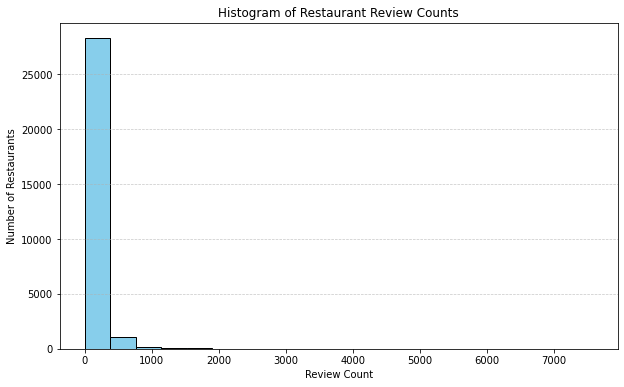

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Step 1: Extract review counts
review_counts_df = spark.sql("""
    SELECT review_count
    FROM metro_restaurants_table
""").toPandas()  # Convert Spark DataFrame to pandas

# Step 2: Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(review_counts_df['review_count'], bins=20, edgecolor='black', color='skyblue')
plt.title('Histogram of Restaurant Review Counts')
plt.xlabel('Review Count')
plt.ylabel('Number of Restaurants')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

In [0]:
spark.sql('''
SELECT DISTINCT(metro_area), COUNT(*) AS restaurant_count, ROUND(AVG(stars),2) AS avg_rating, ROUND(AVG(review_count),2)AS avg_restaurant_review_counts
FROM metro_restaurants_table
GROUP BY metro_area
ORDER BY restaurant_count DESC
''').show()

+-------------+----------------+----------+----------------------------+
|   metro_area|restaurant_count|avg_rating|avg_restaurant_review_counts|
+-------------+----------------+----------+----------------------------+
| Philadelphia|            9539|       3.5|                       85.41|
|        Tampa|            4955|      3.51|                      105.75|
|     St Louis|            2975|      3.33|                       80.03|
|    Nashville|            2558|      3.37|                      107.73|
| Indianapolis|            2494|      3.39|                       86.85|
|  New Orleans|            1951|      3.52|                      195.23|
|     Edmonton|            1549|      3.49|                       28.96|
|       Tucson|            1509|      3.37|                      114.54|
|         Reno|             903|      3.45|                      176.45|
|        Boise|             788|      3.44|                       90.76|
|Santa Barbara|             516|       3.8|        

### 2E.7 Selecting Relevant Fields from Reviews & Metro_Restaurants Table

* The df_reviews contain business_id (the identification of a certain restaurant), and information related to reviews of that business_id.
* The metro_restaurants_table contains business_id, and information related to the restaurants.

JOIN Selection:
  - As the purpose of the project is to summarize reviews for each restaurant, we will use *INNER JOIN* to filter out restaurants without reviews, or reviews without specified restaurants.

Field Selection:

- Field: review_table.business_id
  -  Decision: Include
  - Reason: We would need this to use as a parameter when running the restaurant to summarize.

- Field: review_table.cool
  - Decision: Exclude
  - Reason: Based on our analysis above, reviews with at least 1 cool votes only consist of 595579 reviews. We won't filter reviews based on this, therefore we don't need to include it.

- Field: review_table.date
  - Decision: Include
  - Reason: A restaurant might have improved over time. Therefore, it’s important to consider the date of review

- Field: review_table.funny
  - Decision: Exclude
  - Reason: Not very useful and does not add value to the overall review

- Field: review_table.review_id
  - Decision: Exclude
  - Reason: Since we’re summarizing the reviews, we don’t care about particular reviews, only the general sentiment of all the reviews

- Field: review_table.stars
  - Decision: Include
  - Reason: Gives us an easy way to indicate if the review is in favor (high # of stars) or not in favor (low # of stars) of the restaurant

- Field: review_table.text
  - Decision: Include
  - Reason: This is the actual description of the review we’re summarizing

- Field: review_table.useful
  - Decision: Include
  - Reason: Allows to give identify and give more weights to reviews users consider ‘useful’

- Field: review_table.user_id
  - Decision: Include
  - Reason: Foreign key of user table, which allows us to join to that table

- Field: metro_restaurant_table.business_id
  - Decision: Exclude
  - Reason: primary key allowing us to connect to other table, but we don’t need to show it as we already have the name of restaurant

- Field: metro_restaurant_table.name
  - Decision: Include
  - Reason: Allows us to identify the name of the business we’re summarizing

- Field: metro_restaurant_table.stars
  - Decision: Include
  - Reason: allows us to easily assess if people overall are generally in favor or not in favor of the restaurant

- Field: metro_restaurant_table.review_count
  - Decision: Exclude
  - Reason: Whether a restaurant has low review_count or high review_count, we’re going to summarize its review regardless

- Field: metro_restaurant_table.categories
  - Decision: Include
  - Reason: Shows more info about the restaurant. We need to show this when we're presenting.

- Field: metro_restaurant_table.metro_area
  - Decision: Include
  - Reason: As part of the team project notebook, we need to process data by metro area.



In [0]:
df_restaurant_reviews = spark.sql("""
SELECT r.business_id as business_id, r.date, r.stars AS review_stars, r.text, r.useful AS review_useful, m.review_count, r.user_id, m.name, m.stars AS restaurant_stars, m.categories , m.metro_area
FROM review_table as r
INNER JOIN metro_restaurants_table as m
ON m.business_id = r.business_id
""")


print("Record count:", df_restaurant_reviews.count())

df_restaurant_reviews.createOrReplaceTempView('filtered_review_table')
df_restaurant_reviews.show(vertical = True, truncate = 100)


Record count: 3134929
-RECORD 0----------------------------------------------------------------------------------------------------------------
 business_id      | YjUWPpI6HXG530lwP-fb2A                                                                               
 date             | 2014-02-05 20:30:30                                                                                  
 review_stars     | 3.0                                                                                                  
 text             | Family diner. Had the buffet. Eclectic assortment: a large chicken leg, fried jalapeño, tamale, t... 
 review_useful    | 0                                                                                                    
 review_count     | 47                                                                                                   
 user_id          | 8g_iMtfSiwikVnbP2etR0A                                                                               
 n

###2E.8 Focusing on Reviews With More Engagement
 * By focusing on the reviews that have more engagement and are considered higher quality, with more tags, the data becomes more relevant and relatable for a review summarizer. 
 * This process also allows further analysis of the data and makes it easier to identify trends and customer sentiments.


In [0]:
spark.sql("DESCRIBE TABLE review_table").show()
df_reviews = spark.sql("""
SELECT business_id, text, stars, useful, date, user_id
FROM review_table
WHERE useful > 1
AND YEAR(CAST(date AS DATE)) >= 2015
""")
print("Record count:", df_reviews.count())
df_reviews.show(vertical=True, truncate=80)

+-----------+---------+-------+
|   col_name|data_type|comment|
+-----------+---------+-------+
|business_id|   string|   null|
|       cool|   bigint|   null|
|       date|   string|   null|
|      funny|   bigint|   null|
|  review_id|   string|   null|
|      stars|   double|   null|
|       text|   string|   null|
|     useful|   bigint|   null|
|    user_id|   string|   null|
+-----------+---------+-------+

Record count: 1046388
-RECORD 0---------------------------------------------------------------------------------------
 business_id | LHSTtnW3YHCeUkRDGyJOyw                                                           
 text        | Amazingly amazing wings and homemade bleu cheese. Had the ribeye: tender, per... 
 stars       | 5.0                                                                              
 useful      | 2                                                                                
 date        | 2015-08-07 02:29:16                                          

##2F. Understanding the Relationship between Users and Restaurant Reviews (restaurant_reviews_for_summarization)


###2F.1 Loading User Table

In [0]:
# rebuild user_table & print counts of the record
if spark.catalog._jcatalog.tableExists('user_table'):
  print('user_table already loaded in memory')
else:
  spark.sql(f"""
    CREATE TABLE user_table
    USING PARQUET
    LOCATION '/user/hive/warehouse/user_table'
  """)
  print('user table rebuilt from parquet files.')


spark.sql("""
SELECT COUNT(*) AS review_count
FROM user_table
""").show()

spark.sql("""
SELECT *
FROM user_table
""").show(3, vertical = True, truncate = 30)

user table rebuilt from parquet files.
+------------+
|review_count|
+------------+
|     1987897|
+------------+

-RECORD 0--------------------------------------------
 average_stars      | 3.91                           
 compliment_cool    | 467                            
 compliment_cute    | 56                             
 compliment_funny   | 467                            
 compliment_hot     | 250                            
 compliment_list    | 18                             
 compliment_more    | 65                             
 compliment_note    | 232                            
 compliment_photos  | 180                            
 compliment_plain   | 844                            
 compliment_profile | 55                             
 compliment_writer  | 239                            
 cool               | 5994                           
 fans               | 267                            
 friends            | NSCy54eWehBJyZdG2iE84w, pe4... 
 funny              |

###2F.2 Identifying Review Trends of Users
* This allows us to identify active and inactive users, where we can prioritize relevant reviews, as users who are more active may be more experienced reviewers with more detailed and consistent feedback.
* The users who are not as active may only review a restaurant after an experience that stands out and are outliers, positively or negatively. 
* This allows us to weigh the credibility of the reviews and the users. An honest summarization of the average reviews would be ideal. This allows the summaries to be more accurate, relevant, and insightful.

In [0]:
spark.sql('''
SELECT MIN(review_count) AS lowest_num_of_reviews_by_user,
    MAX(review_count) AS highest_num_of_reviews_by_user,
    ROUND(AVG(review_count),2) AS users_avg_num_of_reviews,
    ROUND(STDDEV(review_count),2) AS stdev_of_num_of_reviews
FROM user_table
''').show()

+-----------------------------+------------------------------+------------------------+-----------------------+
|lowest_num_of_reviews_by_user|highest_num_of_reviews_by_user|users_avg_num_of_reviews|stdev_of_num_of_reviews|
+-----------------------------+------------------------------+------------------------+-----------------------+
|                            0|                         17473|                   23.39|                  82.57|
+-----------------------------+------------------------------+------------------------+-----------------------+



###2F.3 Understanding Distribution of User Review Activity
* Knowing the distribution of user review activity can help prioritize reviews from more active users and handle reviews from users with few contributions in a more nuanced way.
* This can improve the quality and relevance of the summary of reviews.

In [0]:
spark.sql('''
          SELECT 
            CASE
              WHEN review_count BETWEEN 0 AND 10 THEN '0-10'
              WHEN review_count BETWEEN 10 AND 25 THEN '10-25'
              WHEN review_count BETWEEN 25 AND 50 THEN '25-50'
              WHEN review_count BETWEEN 50 AND 100 THEN '50-100'
              WHEN review_count >= 100 THEN '100+'
            END AS review_count_range,
            ROUND((COUNT(user_id) * 100.0 / (SELECT COUNT(*) FROM user_table)), 2) AS percentage_of_reviews_by_users
          FROM user_table 
          GROUP BY review_count_range
          ORDER BY review_count_range
          ''').show()

+------------------+------------------------------+
|review_count_range|percentage_of_reviews_by_users|
+------------------+------------------------------+
|              0-10|                         65.69|
|             10-25|                         16.73|
|              100+|                          4.57|
|             25-50|                          8.23|
|            50-100|                          4.78|
+------------------+------------------------------+



###2F.4 Identifying Patterns in User Behavior & Interactions with Reviews
* Since all variables (useful, funny, cool) are correlated with each other using the benchmark of 0.9, we are going to keep only useful for having the most count.
* This query provides detailed metrics that can be used to refine the business’s understanding of how users interact with reviews. 
* It can help the summarizer prioritize reviews, identify patterns in user behavior, and improve the effectiveness of review management strategies. 
* The data is useful for improving the quality of feedback systems.

In [0]:
spark.sql("""
SELECT
    SUM(CASE WHEN useful > 1 THEN 1 ELSE 0 END) AS useful_count,
    ROUND(CORR(useful, funny),2) AS useful_funny_corr,
    SUM(CASE WHEN funny > 1 THEN 1 ELSE 0 END) AS funny_count,
    ROUND(CORR(funny, cool),2) AS funny_cool_corr,
    SUM(CASE WHEN cool > 1 THEN 1 ELSE 0 END) AS cool_count,
    ROUND(CORR(cool, useful),2) AS cool_useful_corr
FROM 
    user_table
""").show()

+------------+-----------------+-----------+---------------+----------+----------------+
|useful_count|useful_funny_corr|funny_count|funny_cool_corr|cool_count|cool_useful_corr|
+------------+-----------------+-----------+---------------+----------+----------------+
|     1201071|             0.95|     623145|           0.96|    664284|            0.99|
+------------+-----------------+-----------+---------------+----------+----------------+



###2F.5 Comparing the Number of Elite Users to the Total User Base
* Out of 1.99 million users, only 76k or 3.85% have elite badge.
* The count of elite users can help the summarizer identify and target highly engaged and loyal users. These users may be influential in providing valuable feedback or reviews, making them important for marketing or community-building efforts.
* The total user count provides a baseline for understanding the overall scale of the user base.
* By comparing the number of elite users to the total user base, the business can understand the proportion of users who are considered highly engaged or influential.

In [0]:
spark.sql('''
SELECT COUNT(*) AS elite_users
FROM user_table
WHERE  SIZE(SPLIT(elite, ',')) > 1
''').show()

spark.sql('''
SELECT COUNT(*) AS all_users
FROM user_table
''').show()

+-----------+
|elite_users|
+-----------+
|      76615|
+-----------+

+---------+
|all_users|
+---------+
|  1987897|
+---------+



###2F.6 Assessing the General Sentiment of the User Base
* In this analysis, there are some users who only give one star on average as well as users who mostly give five stars. The average number of average stars is 3.63 with a standard deviation of 1.18.
* By examining these metrics, the summarizer can assess the general sentiment of the user base and take into account user satisfaction, identify loyal users, and address any areas of concern where users may be giving poor ratings.

In [0]:
spark.sql('''
SELECT
    ROUND(MEAN(average_stars),2) AS mean_avg_star, 
    ROUND(stddev(average_stars),2) AS stan_dev_of_avg_stars,
    min(average_stars) AS lowest_avg_stars, 
    max(average_stars) AS highest_avg_stars
FROM user_table
''').show()

+-------------+---------------------+----------------+-----------------+
|mean_avg_star|stan_dev_of_avg_stars|lowest_avg_stars|highest_avg_stars|
+-------------+---------------------+----------------+-----------------+
|         3.63|                 1.18|             1.0|              5.0|
+-------------+---------------------+----------------+-----------------+



In [0]:
spark.sql('''
          SELECT YEAR(yelping_since) AS yelping_since,
          ROUND(COUNT(user_id)*100/(SELECT COUNT(*) FROM user_table),2) AS perc_of_users
          FROM user_table
          GROUP BY YEAR(yelping_since)
          ORDER BY yelping_since
          ''').show()

+-------------+-------------+
|yelping_since|perc_of_users|
+-------------+-------------+
|         2004|          0.0|
|         2005|         0.05|
|         2006|         0.27|
|         2007|         0.77|
|         2008|         1.56|
|         2009|         3.27|
|         2010|         5.49|
|         2011|         8.88|
|         2012|         9.86|
|         2013|        10.55|
|         2014|        11.74|
|         2015|        12.47|
|         2016|        10.95|
|         2017|          7.6|
|         2018|         6.72|
|         2019|         5.26|
|         2020|         2.39|
|         2021|         2.04|
|         2022|         0.14|
+-------------+-------------+



In [0]:
spark.sql('''
          SELECT 
          CASE
            WHEN YEAR(yelping_since) BETWEEN 2004 AND 2008 THEN '2004-2008'
            WHEN YEAR(yelping_since) BETWEEN 2008 AND 2012 THEN '2008-2012'
            WHEN YEAR(yelping_since) BETWEEN 2012 AND 2016 THEN '2012-2016'
            WHEN YEAR(yelping_since) BETWEEN 2016 AND 2020 THEN '2016-2020'
            WHEN YEAR(yelping_since) BETWEEN 2020 AND 2022 THEN '2020-2022'
          END AS year_bucket,
          ROUND((COUNT(user_id) * 100.0 / (SELECT COUNT(*) FROM user_table)), 2) AS percentage_of_users
          FROM user_table 
          GROUP BY year_bucket
          ORDER BY year_bucket
          ''').show()


+-----------+-------------------+
|year_bucket|percentage_of_users|
+-----------+-------------------+
|  2004-2008|               2.66|
|  2008-2012|              27.48|
|  2012-2016|              45.71|
|  2016-2020|              21.97|
|  2020-2022|               2.18|
+-----------+-------------------+



###2F.7 Joining the Tables: user_table and restaurant reviews
##Field Selection
* **Field:** user_table.user_id
  * **Reason:** Necessary primary key to connect with review table

* **Field:** user_table.review_count
  * **Reason:** Users with a higher number of reviews have more experience with reviewing restaurants, making their opinions more informed and valuable.


* **Field:** user_table.yelping_since
  * **Reason:** Longer membership on Yelp may indicate credibility and more experienced reviews, providing more reliable insights.


* **Field:** user_table.useful
  * **Reason:** A higher number of useful votes suggests that other users find this person's reviews helpful, adding credibility to their opinions.
  

* **Field:** user_table.elite
  * **Reason:** The user being an elite member adds weight to their reviews, as elite members are typically more active and recognized for their quality contributions.


* **Field:** user_table.average_stars
  * **Reason:** Average rating indicates the user's general sentiment towards restaurants and can provide context about their reviewing style or expectations.


* **Field:** user_table.fans

* **Decision:** Exclude

* **Reason:** Although we have the assumption that users who have more followers tend to receive more useful for their reviews, as the followers will receive notifications and the reveiws will be more exposed and thus likely to get more response.

   However, actually there's no real-time notificaions push to followers. Instead, thier public contributions (reviews, photos, check-ins, etc.) will be visible in a follower's feed. [Yelp Support Center](https://www.yelp-support.com/article/What-does-it-mean-to-follow-another-user?l=en_US)

  We make the conclusion that we will consider the field "useful" as it only represent how useful the review is regardless of the reviewer's followers. 



In [0]:
df_restaurant_reviews_with_users = spark.sql("""
SELECT r.*, u.review_count as user_review_count, u.yelping_since, u.useful AS user_useful, u.elite, u.average_stars AS user_average_stars
FROM filtered_review_table AS r
INNER JOIN user_table AS u
ON r.user_id = u.user_id
""")


# Show the result
#df_restaurant_reviews_with_users.show(vertical = True, truncate = 100)

print("Record count:", df_restaurant_reviews_with_users.count())
df_restaurant_reviews_with_users.show(3, truncate = 100, vertical = True )


Record count: 3134922
-RECORD 0------------------------------------------------------------------------------------------------------------------
 business_id        | tIvfmgT1qMeAEQf8CI5fPQ                                                                               
 date               | 2014-09-06 01:09:35                                                                                  
 review_stars       | 4.0                                                                                                  
 text               | Ate dinner there tonight. Service was pretty fast and very nice. In fact, she might have tried a ... 
 review_useful      | 1                                                                                                    
 review_count       | 574                                                                                                  
 user_id            | --Kwhcbkh7jxkhVVQZo2uQ                                                                  

###2F.8 Segmenting the Elite Users Based on Their average_stars
* By identifying users with more than one elite designation, the summarizer can easily identify those who are highly engaged and influential.
* The average_stars column provides insight into the typical ratings given by users, which can be useful for understanding the general sentiment of the user base.
* By segmenting the elite users based on their average_stars, the summarizer can identify if elite users tend to rate businesses higher or lower, providing insights into their preferences and behavior. 
* With all the additional user information, the summarizer can enhance the review summarization process. For example, it can prioritize reviews from more experienced or influential users (like elite users or users with high fan counts).
* It can also create more meaningful summaries or analyses by grouping reviews based on user characteristics (e.g., reviews from users with higher average_stars might be weighted differently in summaries).
* Combining user information with review content makes it easier to perform sentiment analysis on reviews from highly engaged users

##2G. Preparing and Analyzing Tip Table for Summarization
*Tips are shorter than reviews and tend to convey quick suggestions.*

We select
- business_id: to match the business with restaruant dataframe 
- text: content of the tip

### 2G.1 Visualizing Customer Engagement Trends (compliment counts)

* This code visualizes customer engagement trends by creating a histogram of compliment counts from the dataset. 
* It extracts data on compliments, converts it into a suitable format, and generates an informative plot to showcase the distribution of compliments received by businesses.
* This can help us understand the patterns of compliments and customer satisfaction.

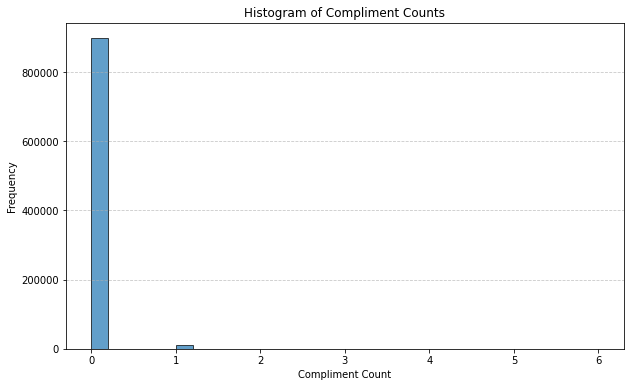

In [0]:
import matplotlib.pyplot as plt

df_raw_tips.createOrReplaceTempView("raw_tips")

# Query to extract compliment_count from the dataset
compliment_count_data = spark.sql("""
SELECT compliment_count
FROM raw_tips
""")

# Convert the compliment_count data to Pandas for plotting
compliment_count_pd = compliment_count_data.toPandas()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(compliment_count_pd['compliment_count'], bins=30, edgecolor='black', alpha=0.7)  # Adjust bins for resolution

# Add labels and title
plt.title("Histogram of Compliment Counts")
plt.xlabel("Compliment Count")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


###2G.2 Extracting & Organizing Customer Tip Data for Analysis
* This code extracts business IDs and customer tip text from the dataset, organizes it into a new table (tips), and provides a quick overview of the data while counting the total number of tips available.
* This helps us prepare the data for further insights. This efficiently organizes the relevant data for analysis.


In [0]:
#2c2
df_tips = spark.sql("""
SELECT  business_id, text
FROM raw_tips 
""")
df_tips.show(vertical = True, truncate = False)

df_tips.createOrReplaceTempView("tips")

df_tips.count()

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 business_id | 3uLgwr0qeCNMjKenHJwPGQ                                                                                                                                                                                       
 text        | Avengers time with the ladies.                                                                                                                                                                               
-RECORD 1-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 business_id | QoezRbYQncpRqyrLH6Iqjg                                                                               

###2G.3 Analyzing & Visualizing Customer Tip Length

* This code analyzes the word count distribution of customer tips from a dataset. It visualizes the data through a histogram, highlighting the median word count, and focuses on tips with up to 50 words to reveal patterns in customer feedback length. 
* This can help us understand the customer feedback trends, which in turn can support feedback optimization, and deeper analysis of the data.

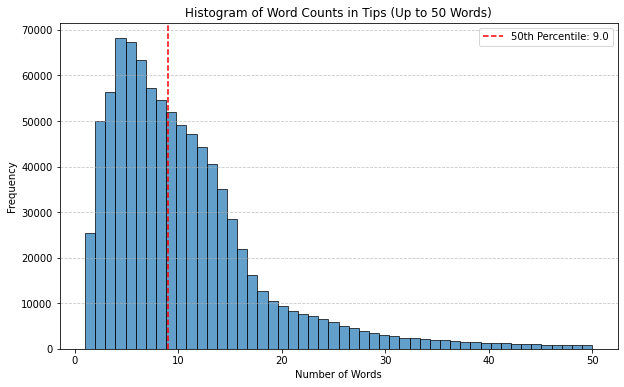

In [0]:
#2c3
import matplotlib.pyplot as plt
import numpy as np

# Query to calculate word count for each tip
tip_word_count_data = spark.sql("""
SELECT SIZE(SPLIT(text, ' ')) AS word_count
FROM raw_tips
""")

# Convert the word count data to Pandas for plotting
tip_word_count_pd = tip_word_count_data.toPandas()

# Filter the data to include only tips with up to 50 words
tip_word_count_pd_filtered = tip_word_count_pd[tip_word_count_pd['word_count'] <= 50]

# Calculate the 50th percentile (median)
median_word_count = np.percentile(tip_word_count_pd['word_count'], 50)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(tip_word_count_pd_filtered['word_count'], bins=50, edgecolor='black', alpha=0.7)

# Add a vertical line for the 50th percentile
plt.axvline(x=median_word_count, color='red', linestyle='--', linewidth=1.5, label=f"50th Percentile: {median_word_count:.1f}")

# Add labels and title
plt.title("Histogram of Word Counts in Tips (Up to 50 Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.show()


### 2G.4 Combining Tips Table 

In [0]:
df_restaurant_reviews_with_users.createOrReplaceTempView("df_review_users")

df_restaurant_reviews_for_summarization = spark.sql("""
SELECT l.*, t.text AS tip, t.compliment_count AS tip_compliment_count
FROM df_review_users AS l
LEFT JOIN raw_tips AS t
ON l.business_id = t.business_id AND
l.user_id = t.user_id
""")

print("Record count:", df_restaurant_reviews_for_summarization.count())
df_restaurant_reviews_for_summarization.show(3, truncate = 100, vertical = True )

Record count: 3184312
-RECORD 0--------------------------------------------------------------------------------------------------------------------
 business_id          | 0qu0fNTOsSmuREYVIMPuIQ                                                                               
 date                 | 2020-10-29 23:34:47                                                                                  
 review_stars         | 4.0                                                                                                  
 text                 | Cool little place hidden way out in no mans land. Food was good, but came out quick & cold tellin... 
 review_useful        | 0                                                                                                    
 review_count         | 1018                                                                                                 
 user_id              | --2F5G5LKt3h2cAXJbZptg                                                  

##2H Organizing Restaurant Reviews for Summarization into a Table
* This new table contains the latest, more relevant data, which assists the summarizer in making higher quality summaries. This way, the data is more centralized, efficient, and simplified.

In [0]:
SUMMARIZATION_TABLE_NAME = 'restaurant_reviews_for_summarization_table'

if (spark.catalog._jcatalog.tableExists(SUMMARIZATION_TABLE_NAME)):
  spark.sql(f'DROP TABLE {SUMMARIZATION_TABLE_NAME}')
try:
  dbutils.fs.rm(f'/user/hive/warehouse/{SUMMARIZATION_TABLE_NAME}', recurse=True)
except Exception:
  pass
df_restaurant_reviews_for_summarization.write.mode("overwrite").format('parquet').saveAsTable(SUMMARIZATION_TABLE_NAME)

###2H.1 Creating a Comprehensive Dataset

* We join every table with business_id, except we join user table with the final table with user_id
* This query creates a comprehensive dataset by combining several tables that each contain unique pieces of information. The result will have all the relevant data about restaurants, reviews, user engagement (tips and reviews), and metro areas, making it ideal for business analysis, such as customer behavior analysis, restaurant performance, or regional performance comparisons.
* Understanding review patterns, user feedback on restaurants, and the overall sentiment can aid in creating automated review summarizers or sentiment analysis tools that provide insights on restaurant performance, user satisfaction, or sentiment in different areas.
* This query helps in aggregating multiple sources of data, providing a deeper understanding of how users interact with restaurants.
* It gives us valuable insights, such as:
  * How user reviews (including tips) are distributed across metro areas,
  * The relationship between restaurant ratings, user activity, and review volumes,
  * Regional variations in restaurant ratings or user engagement, etc.



###2H.2 Cleaning Up Data for Improved Efficiency
In order to save space in memory, we dropped all the preliminary tables to maintain a clean and efficient data environment.
This supports:
* Data hygiene
* Resource management
* Efficient data workflow


In [0]:
spark.sql('DROP TABLE metro_restaurants_table')
spark.sql('DROP TABLE review_table')
spark.sql('DROP TABLE user_table')

Out[68]: DataFrame[]

##Summarization of Final Data Wrangling Notebook
* We filtered and wrangled the data to provide quality data for an accurate summarization of restaurant reviews.
* When presenting new data, we analyzed and understood the contents and structure of the data.
* When researching deeper into the data for Restaurants, Metro Areas, Users, Tips, etc., we noticed redundancies, data of poor quality, and irrelevant information.
* Using data-driven insights and business reasoning, we made decisions on what parts of the data we would include and exclude.
  * The data that we decided were not helpful for a summarization of restaurant reviews were excluded and filtered out.
  * This process applied to almost every data component, from Restuarants, to Categories, to Tips.
* Additionally, we studied the relationship between Restaurants, Reviews, Users, and more.
  * This helped us understand what Yelp users valued in restaurant reviews, and helped us evaluate the importance of the reviews.
* With thorough analysis and refinement of the data, we were able to narrow the data to what we feel is most relevant for a restaurant review summarizer.